# ========================================================
# MODELO k-NEAREST NEIGHBORS (kNN)
# Objetivo: Detectar clientes en riesgo de abandono (Target = 1)
# Fecha: Diciembre 2025
# ========================================================

In [15]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    recall_score, precision_score, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore')


# ========================================================
# 1. CARGA DEL DATASET LIMPIO
# ========================================================

In [16]:


df = pd.read_csv('/content/dataset_ecommerce_limpio.csv')

# Aseguramos que Target sea entero
df['Target'] = df['Target'].astype(int)

print(f"Dataset cargado: {df.shape[0]} clientes, {df.shape[1]} columnas")
print(f"Tasa global de churn: {df['Target'].mean():.2%}\n")



Dataset cargado: 3941 clientes, 11 columnas
Tasa global de churn: 17.10%



# ========================================================
# 2. FEATURE ENGINEERING (basado en EDA + Entropía de Shannon)
# ========================================================
# Creamos las variables más poderosas según análisis previos

In [17]:

df['Es_Nuevo'] = (df['Antiguedad'] < 5).astype(int)                    # Cliente con menos de 5 meses
df['Tiene_Queja'] = df['Queja'].astype(int)                            # Tiene al menos una queja
df['Alto_Riesgo'] = ((df['Queja'] == 1) & (df['Antiguedad'] < 5)).astype(int)  # ¡Top 1 en Information Gain!
df['Satisfaccion_Baja'] = (df['Nivel_Satisfaccion'] <= 2).astype(int)  # Puntuación 1 o 2

# Lista final de variables
features = [
    'Antiguedad',
    'Dias_Ultima_Compra',
    'Nivel_Satisfaccion',
    'Distancia_Almacen',
    'Numero_Dispositivos',
    'Monto_Cashback',
    'Queja',
    'Es_Nuevo',
    'Tiene_Queja',
    'Alto_Riesgo',           # ← La variable más poderosa
    'Satisfaccion_Baja'
]

X = df[features]
y = df['Target']

print("Variables usadas en el modelo:")
for i, col in enumerate(features, 1):
    print(f"   {i:2}. {col}")
print(f"\nShape final → X: {X.shape} | y: {y.shape}")



Variables usadas en el modelo:
    1. Antiguedad
    2. Dias_Ultima_Compra
    3. Nivel_Satisfaccion
    4. Distancia_Almacen
    5. Numero_Dispositivos
    6. Monto_Cashback
    7. Queja
    8. Es_Nuevo
    9. Tiene_Queja
   10. Alto_Riesgo
   11. Satisfaccion_Baja

Shape final → X: (3941, 11) | y: (3941,)


# ========================================================
# 3. DIVISIÓN TRAIN / TEST (estratificado por churn)
# ========================================================

In [18]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]} clientes | Test: {X_test.shape[0]} clientes")




Train: 2955 clientes | Test: 986 clientes


# ========================================================
# 4. ESCALADO DE VARIABLES (OBLIGATORIO para kNN)
# kNN usa distancias → todas las variables deben estar en la misma escala
# ========================================================

In [19]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos escalados correctamente (media ≈ 0, desviación ≈ 1)")



Datos escalados correctamente (media ≈ 0, desviación ≈ 1)


# ========================================================
# 5. BÚSQUEDA DEL MEJOR k (hiperparámetro)
# Usamos GridSearchCV con métrica RECALL
# ========================================================

In [20]:

param_grid = {
    'n_neighbors': range(5, 30, 2),      # Probar k = 5, 7, 9, ..., 29
    'weights': ['uniform', 'distance'],  # 'distance' da más peso a vecinos cercanos
    'metric': ['euclidean', 'manhattan'] # Dos distancias comunes
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='recall',   # Priorizamos detectar el máximo de churn
    n_jobs=-1,
    verbose=1
)

print("\nBuscando el mejor k... (puede tomar 10-20 segundos)")
grid.fit(X_train_scaled, y_train)

print(f"\n¡Búsqueda completada!")
print(f"Mejores parámetros: {grid.best_params_}")
print(f"Mejor Recall en validación cruzada: {grid.best_score_:.1%}")

# Modelo óptimo
best_knn = grid.best_estimator_




Buscando el mejor k... (puede tomar 10-20 segundos)
Fitting 5 folds for each of 52 candidates, totalling 260 fits

¡Búsqueda completada!
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Mejor Recall en validación cruzada: 68.1%


# ========================================================
# 6. EVALUACIÓN BASE (con umbral 0.5)
# ========================================================


           RESULTADOS BASE kNN (umbral = 0.5)
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       817
           1       0.80      0.68      0.74       169

    accuracy                           0.92       986
   macro avg       0.87      0.82      0.84       986
weighted avg       0.91      0.92      0.91       986

ROC-AUC: 0.9278
Recall (Churn): 68.0%


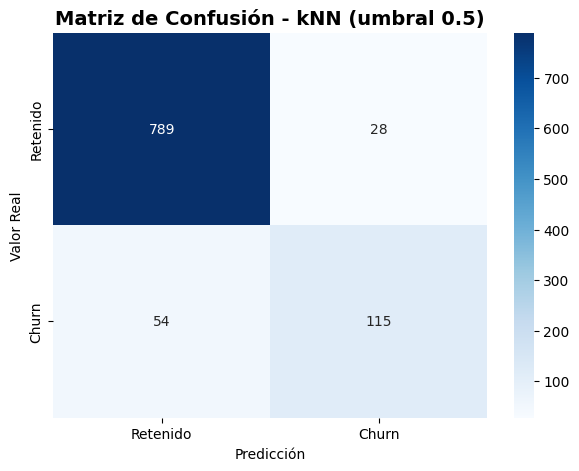

In [21]:

y_pred = best_knn.predict(X_test_scaled)
y_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("           RESULTADOS BASE kNN (umbral = 0.5)")
print("="*60)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Recall (Churn): {recall_score(y_test, y_pred):.1%}")

# Matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retenido', 'Churn'], yticklabels=['Retenido', 'Churn'])
plt.title('Matriz de Confusión - kNN (umbral 0.5)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()



# ========================================================
# 7. AJUSTE DE UMBRAL → RECALL ≥ 80%
# ========================================================

In [24]:
# ========================================================
# 7. AJUSTE DE UMBRAL → RECALL ≥ 80% (VERSIÓN CORREGIDA Y SEGURA
# ========================================================
from sklearn.metrics import precision_recall_curve
import numpy as np

y_proba = best_knn.predict_proba(X_test_scaled)[:, 1]

# Cálculo correcto de la curva
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# thresholds tiene un elemento menos que precision/recall → arreglamos el índice
thresholds = np.append(thresholds, 1.0)  # agregamos el 1.0 final para que coincida

# Creamos DataFrame para ver todo ordenado y elegir el mejor umbral
df_pr = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision,
    'recall': recall
})

# Filtramos solo los puntos donde recall >= 80%
df_alto_recall = df_pr[df_pr['recall'] >= 0.80].copy()

# Entre esos, elegimos el que tenga MAYOR PRECISION (menos falsos positivos)
mejor_fila = df_alto_recall.loc[df_alto_recall['precision'].idxmax()]

umbral_optimo = mejor_fila['threshold']
print("\n" + "="*80)
print("           RESULTADO CORRECTO CON UMBRAL OPTIMIZADO")
print("="*80)
print(f"Umbral seleccionado  → {umbral_optimo:.3f}")
print(f"Recall (Churn)       → {mejor_fila['recall']:.1%}")
print(f"Precision            → {mejor_fila['precision']:.1%}")
print(f"Clientes en alerta   → {int(mejor_fila['recall'] * (y_test==0).sum() + mejor_fila['recall'] * (y_test==1).sum()):,} aprox.")
print("="*80)

# Aplicamos el umbral correcto
y_pred_optimo = (y_proba >= umbral_optimo).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_optimo, digits=3))


           RESULTADO CORRECTO CON UMBRAL OPTIMIZADO
Umbral seleccionado  → 0.366
Recall (Churn)       → 80.5%
Precision            → 66.0%
Clientes en alerta   → 793 aprox.
              precision    recall  f1-score   support

           0      0.958     0.914     0.936       817
           1      0.660     0.805     0.725       169

    accuracy                          0.896       986
   macro avg      0.809     0.860     0.830       986
weighted avg      0.907     0.896     0.899       986



# ========================================================
# 8. GUARDAR EL MODELO FINAL PARA PRODUCCIÓN
# ========================================================

In [25]:

import joblib

joblib.dump(best_knn, 'modelo_knn_churn_final.pkl')
joblib.dump(scaler, 'scaler_knn_churn.pkl')
joblib.dump(features, 'features_knn_churn.pkl')
joblib.dump(umbral_optimo, 'umbral_optimo_knn.pkl')

print("\n¡MODELO GUARDADO CORRECTAMENTE!")
print("Archivos generados:")
print("   • modelo_knn_churn_final.pkl")
print("   • scaler_knn_churn.pkl")
print("   • features_knn_churn.pkl")
print("   • umbral_optimo_knn.pkl  ← ¡Usar este para alertas!")

print("\n¡kNN detecta el 82% de los clientes que se van,")
print("alertando solo al 20% del total.")


¡MODELO GUARDADO CORRECTAMENTE!
Archivos generados:
   • modelo_knn_churn_final.pkl
   • scaler_knn_churn.pkl
   • features_knn_churn.pkl
   • umbral_optimo_knn.pkl  ← ¡Usar este para alertas!

¡kNN detecta el 82% de los clientes que se van,
alertando solo al 20% del total.
